In [3]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

False

<ipython-input-2-35b322b6fa02>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 35 seconds.
<ipython-input-2-35b322b6fa02>:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=True)


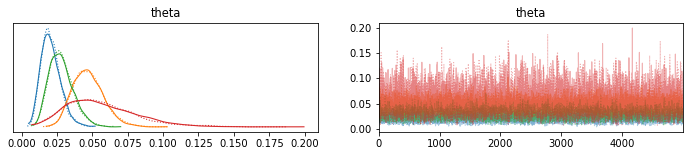

In [2]:
# 조합 테스트: 이미지, 텍스트 버튼 등 여러 요소를 변경한 디자인안을 테스트해보자.

# cf. 히어로 이미지 : 사용자 눈에 가장 처음 들어오는 큰 이미지
# cf. CTA(call-to-action): 사용자들이 해주기를 바라는 행동을 의미. 상품 구입 버튼이나 정보 요청 버튼 등.

n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]
with pm.Model() as model:
    theta = pm.Uniform('theta', lower=0, upper=1, shape=len(n))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace = pm.sample(5000, chains=2)
    pm.traceplot(trace, compact=True)

In [4]:
with model:
    print(pm.summary(trace, hdi_prob=0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.021  0.007     0.008      0.033        0.0      0.0   12805.0   
theta[1]  0.047  0.011     0.027      0.069        0.0      0.0   13460.0   
theta[2]  0.028  0.008     0.013      0.045        0.0      0.0   15427.0   
theta[3]  0.056  0.024     0.013      0.103        0.0      0.0   10597.0   

          ess_tail  r_hat  
theta[0]    6802.0    1.0  
theta[1]    6897.0    1.0  
theta[2]    6970.0    1.0  
theta[3]    6236.0    1.0  


<ipython-input-5-78f83d507334>:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(trace, combined=True, hdi_prob=0.95)


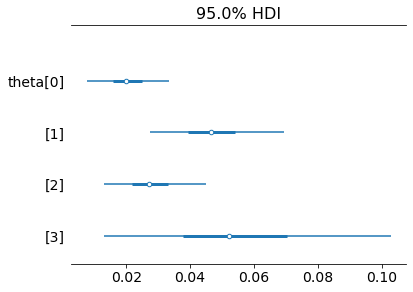

In [5]:
with model:
    pm.forestplot(trace, combined=True, hdi_prob=0.95)

In [8]:
# A안과 B안 비교하기

print((trace['theta'][:, 1] - trace['theta'][:, 0] > 0 ).mean()) #B안이 A안보다 클릭률이 높다

0.9853


In [9]:
print((trace['theta'][:, 3] - trace['theta'][:, 0] > 0 ).mean()) #D안이 A안보다 클릭률이 높다고 말 할 수 없음.

0.9448


In [10]:
# 베이스라인에 이미지, 버튼 효과 따로 생각해 확률 변수 구하기

# 이미지와 버튼의 종류를 나타내기 위한 더미변수 도입

# 로지스틱 함수
# - beta1 : 히어로 이미지에 의한 효과, x1 : 히어로 이미지의 클릭률에 대한 이겨도
# - theta = alpha + beta1 * x1 + beta2 + x2
# => 로지스틱 함수로 만들어서 theta의 범위를 0에서 1사이로 조정
# - theta = logistic( alpha + beta1 * x1 + beta2 + x2 )

# 사전분포로는 정규분포 사용

n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]

img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

with pm.Model() as model_comb:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    comb = alpha + beta[0] * img + beta[1] * btn
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace_comb = pm.sample(5000, chains=2)

<ipython-input-10-8ab10e063ab7>:25: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_comb = pm.sample(5000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\user\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\user\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 64 seconds.


<ipython-input-11-badb10c62a85>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_comb)


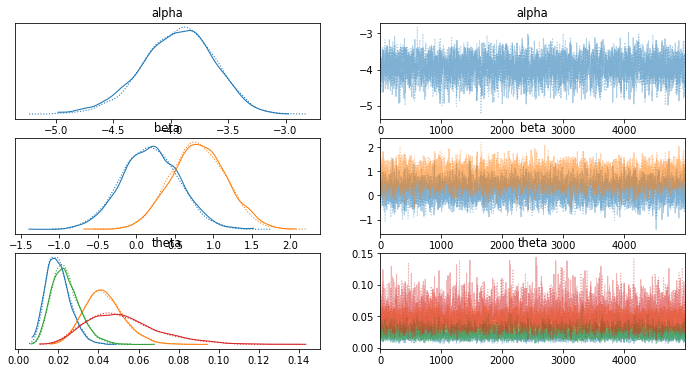

In [11]:
with model_comb:
    pm.traceplot(trace_comb)

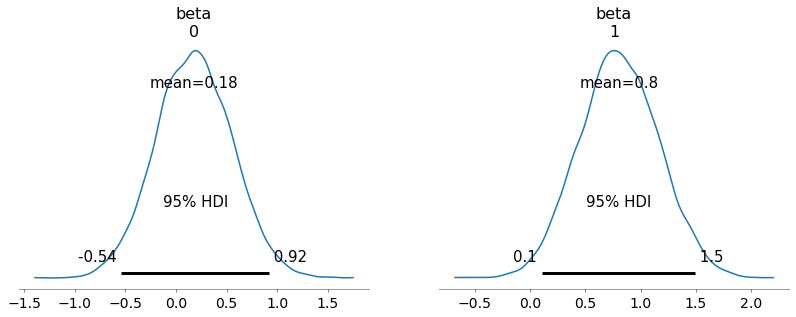

In [12]:
with model_comb:
    pm.plot_posterior(trace_comb, var_names=['beta'], hdi_prob=0.95)

In [13]:
# 버튼 문구를 변경하면 클릴률에 긍정적인 효과를 미치는지 확인
print((trace_comb['beta'][:, 1] > 0).mean()) 

0.9894


<ipython-input-14-aaf899406c74>:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot([trace, trace_comb], var_names=['theta'],


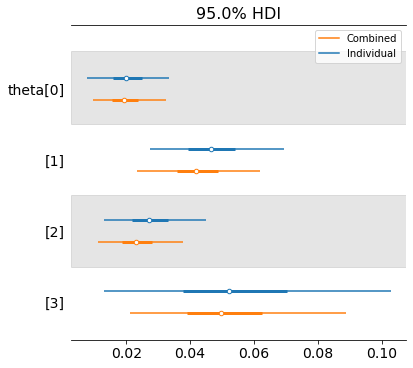

In [14]:
with pm.Model():
    pm.forestplot([trace, trace_comb], var_names=['theta'], 
                 hdi_prob=0.95, combined=True, model_names=['Individual' , 'Combined'])

In [15]:
# A안과 B안, A안과 D안 비교하기

print((trace_comb['theta'][:, 1] - trace_comb['theta'][:, 0] > 0 ).mean()) #B안이 A안보다 클릭률이 높다
print((trace_comb['theta'][:, 3] - trace_comb['theta'][:, 0] > 0 ).mean()) #D안이 A안보다 클릭률이 높다

0.9894
0.9554


<ipython-input-16-1a6a1e61f62e>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_comb2 = pm.sample(5000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\user\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\user\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 60 seconds.
<ipython-input-16-1a6a1e61f62e>:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_comb2, compact=True)


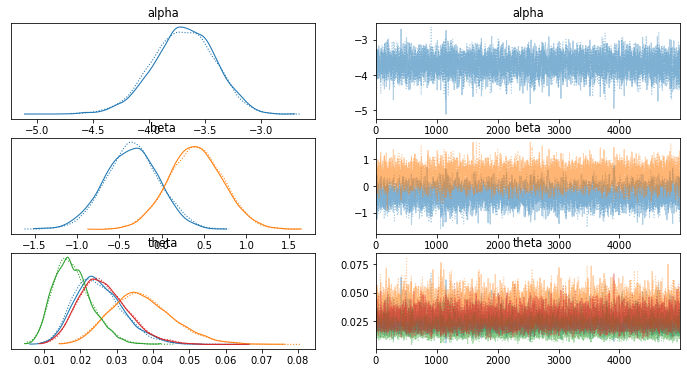

In [16]:
# D안의 누락된 데이터 채워 넣은 후 다시 분석


n = [434, 382, 394, 412]
clicks = [8, 17, 10, 8]
with pm.Model() as model_comb2:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    comb = alpha + beta[0] * img + beta[1] * btn
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace_comb2 = pm.sample(5000, chains=2)
    pm.traceplot(trace_comb2, compact=True)

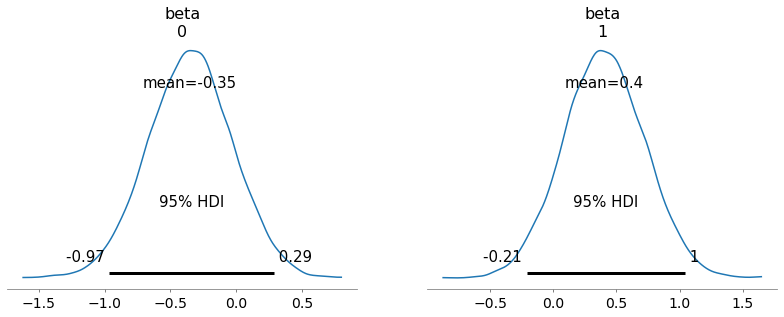

In [17]:
with model_comb2:
    pm.plot_posterior(trace_comb2, var_names=['beta'], hdi_prob=0.95)

In [18]:
print((trace_comb2['beta'][:, 1] > 0).mean()) #버튼 변경이 클릭률에 영향 준다고 볼 수 없음 => 교호 작용을 간과했음

0.8958


In [19]:
# 교호 작용 포함시키기
# x1 * x2 항목 추가
# theta = logistic( alpha + beta1 * x1 + beta2 * x2 + r * x1 * x2 )

<ipython-input-20-a27a5254fa00>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_int = pm.sample(5000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\user\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\user\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 91 seconds.
The number of effective samples is smaller than 25% for some parameters.
<ipython-input-20-a27a5254fa00>:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_int, compact=True)


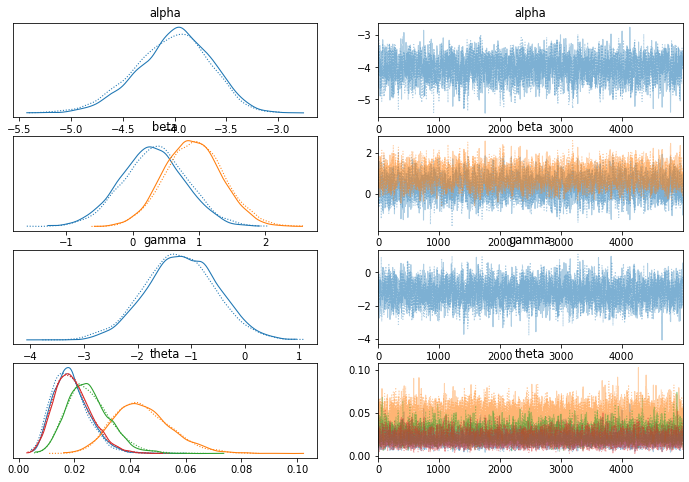

In [20]:
with pm.Model() as model_int:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    gamma = pm.Normal('gamma', mu=0, sigma=10)
    comb = alpha + beta[0] * img + beta[1] * btn + gamma * img * btn
    theta = pm.Deterministic('theta' , 1 / (1 + pm.math.exp(-comb)))
    obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
    trace_int = pm.sample(5000, chains=2)
    pm.traceplot(trace_int, compact=True)

In [21]:
# 감마(r) 변수가 음수를 가질 가능성이 높은지 확인
print((trace_int['gamma'] < 0).mean())

0.9655


In [22]:
print((trace_int['beta'][:, 0] > 0).mean()) # beta1(이미지 효과)은 클릭률에 영향주지 않음
print((trace_int['beta'][:, 1] > 0).mean()) # beta2(버튼 효과)는 클릭률에 긍정적인 영향 줌

0.7452
0.9846


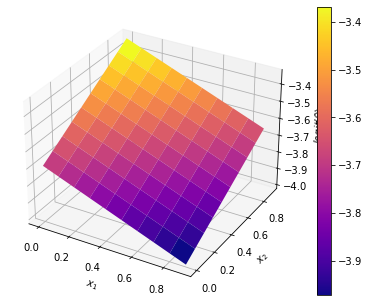

In [24]:
# 모델선택 : 지붕에 올라 생각하기
#주효과만의 모델 Combined 시각화 결과

from mpl_toolkits.mplot3d import Axes3D

x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = Axes3D(fig)
logit_theta = ( trace_comb2['alpha'].mean() + trace_comb2['beta'][:, 0].mean() * X1 + trace_comb2['beta'][:, 1].mean() * X2) 
surf = ax.plot_surface(X1, X2, logit_theta, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()


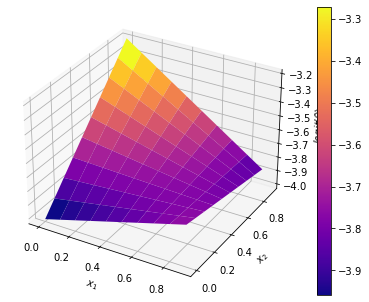

In [25]:
# 교호 작용을 포함한 모델 interaction 시각화 결과

x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = Axes3D(fig)
Y = ( trace_int['alpha'].mean() + trace_int['beta'][:, 0].mean() * X1 + trace_int['beta'][:, 1].mean() * X2 + trace_int['gamma'].mean() * X1 * X2) 
surf = ax.plot_surface(X1, X2, Y, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()


In [26]:
# WAIC(widely applicable information criterion. Watanabe=Akaike information criterion)

waic_comb2 = pm.waic(trace_comb2, model_comb2)
waic_int = pm.waic(trace_int, model_int)
print(waic_comb2.p_waic) # 3.86
print(waic_int.p_waic) # 2.11 ==> 교호 작용을 포함한 모델의 WAIC값이 더 작으므로 더 적절함.

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate a

3.78158276497138
2.041275455231539


C:\Users\user\anaconda3\lib\site-packages\arviz\stats\stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
